In [272]:
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm
import cv2 as cv
import numpy as np

In [273]:
DATASET_PATH = "./archive"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annotations")
IMAGES_PATH = path.join(DATASET_PATH, "images")

## Random Sample

Image shape: (242, 400, 4)


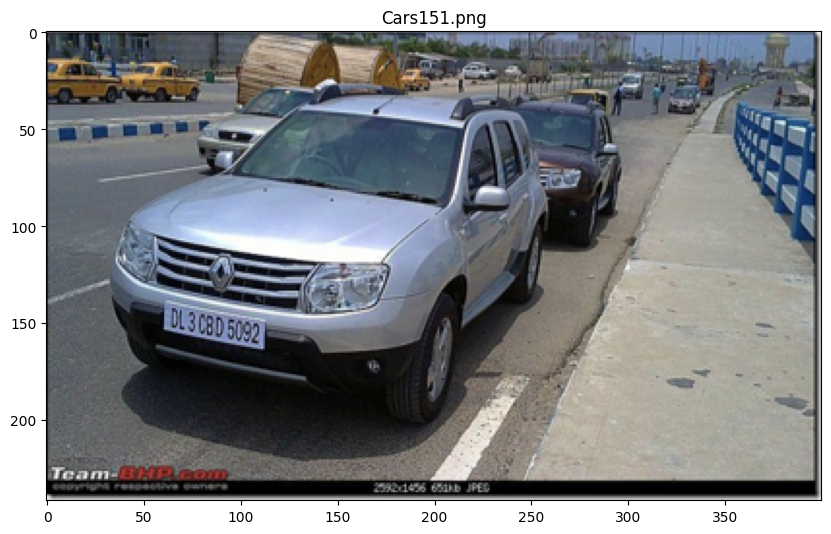

In [274]:
image_filenames = list(walk(IMAGES_PATH))
image_filename = rd.choice(image_filenames[0][2])
image_path = path.join(image_filenames[0][0], image_filename)
img = plt.imread(image_path)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
print('Image shape: {}'.format(img.shape))

In [275]:
annotation = image_filename.split('.')[0] + '.xml'
annotation_path = path.join(ANNOTATIONS_PATH, annotation)
print('Annotation path: {}'.format(annotation_path))

with open(annotation_path, 'r') as f:
    print(f.read())

Annotation path: ./archive/annotations/Cars151.xml

<annotation>
    <folder>images</folder>
    <filename>Cars151.png</filename>
    <size>
        <width>400</width>
        <height>242</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>54</xmin>
            <ymin>135</ymin>
            <xmax>120</xmax>
            <ymax>178</ymax>
        </bndbox>
    </object>
</annotation>


In [276]:
from alprLib.PlateBoundingBox import PlateBoundingBox

plate = PlateBoundingBox(annotation_path)
plate.describe()

PlateBoundingBox
xml_path: ./archive/annotations/Cars151.xml
xmin: 54
ymin: 135
xmax: 120
ymax: 178
width: 66
height: 43
center: (87.0, 156.5)
area: 2838



## Draw Bounding Box on image

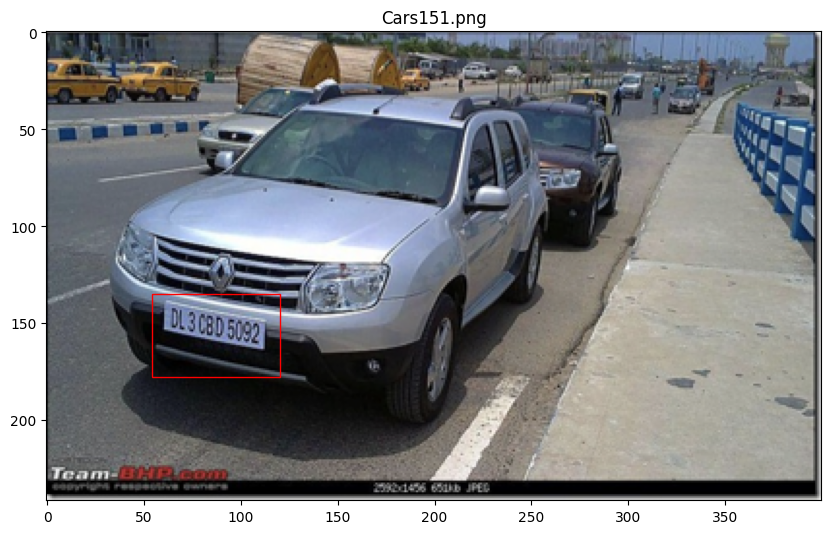

In [277]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
rect = patches.Rectangle((plate.xmin, plate.ymin), plate.width, plate.height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Load Everything in RAM

In [278]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    img = cv.imread(image_path)
    raw_imgs.append(img)

    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    annotations.append(PlateBoundingBox(annotation_path))

  0%|          | 0/433 [00:00<?, ?it/s]

100%|██████████| 433/433 [00:11<00:00, 38.91it/s]


## Gray Scale

In [279]:
grayscale_imgs = []

for image in raw_imgs:
    grayscale_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    blurred_img = cv.GaussianBlur(grayscale_img, ksize=(3, 3), sigmaX=0)  # gaussian blur 

    thresh_img = cv.adaptiveThreshold(
        blurred_img, 
        maxValue=255.0, 
        adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv.THRESH_BINARY_INV, 
        blockSize=19, 
        C=9
    )

    grayscale_imgs.append(thresh_img)

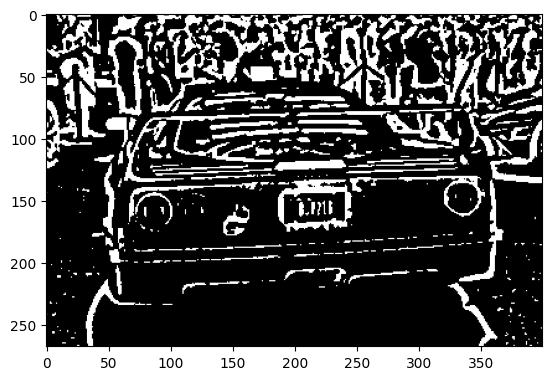

In [280]:
plt.imshow(rd.choice(grayscale_imgs), cmap='gray')
#plt.imshow(grayscale_images[0], cmap='gray')

## Contours

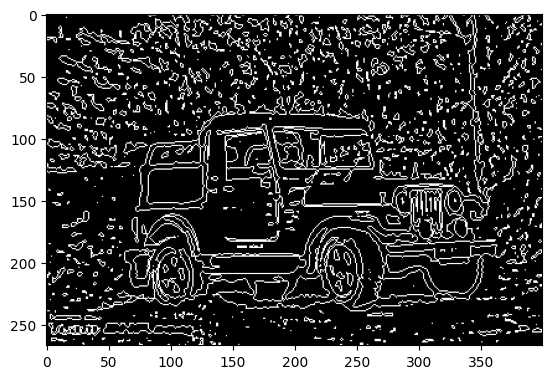

In [281]:
contours_imgs = []

img_contours = []

for image in grayscale_imgs:
    contours, _= cv.findContours(
        image, 
        mode=cv.RETR_LIST, 
        method=cv.CHAIN_APPROX_SIMPLE
    )
    img_contours.append(contours)

    img_contour = np.zeros(image.shape, dtype=np.uint8)

    cv.drawContours(img_contour, contours=contours, contourIdx=-1, color=(255, 255, 255))

    contours_imgs.append(img_contour)


plt.imshow(rd.choice(contours_imgs), cmap='gray')

## Bounding Box extraction

In [ ]:
plates = []

for i in range(len(grayscale_imgs)):
    img = grayscale_imgs[i]
    plate = annotations[i]
    xmin = plate.xmin
    ymin = plate.ymin
    xmax = plate.xmax
    ymax = plate.ymax
    plates.append(img[ymin:ymax, xmin:xmax])

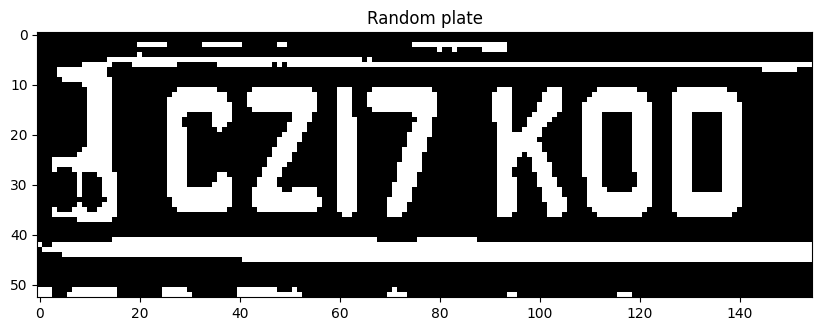

In [ ]:
# show a random plate
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Random plate')
ax.imshow(rd.choice(plates), cmap='gray')

## Perspective Correction

In [ ]:
# perspective correction of plates
## coutours

## corners

## warp perspective

## Contours to Rectangles

Once we have the image of the plate, we can find the contours of the characters so that we can later extract them and feed them to the model.

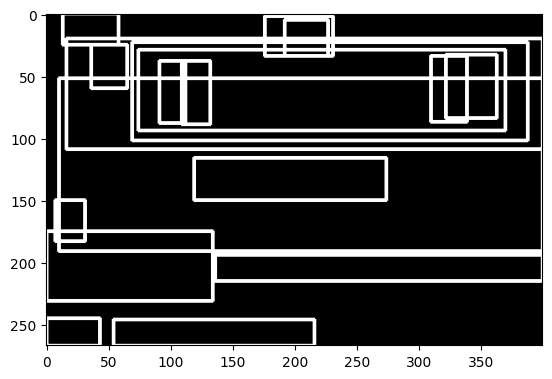

In [285]:
bb_imgs = []

for i in range(len(img_contours)):
    img_contour = img_contours[i]
    bb_img = np.zeros(contours_imgs[i].shape, dtype=np.uint8)
    for contour in img_contour:
        x, y, w, h = cv.boundingRect(contour)
        if w > 20 and h > 20:
            cv.rectangle(bb_img, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

    bb_imgs.append(bb_img)

plt.imshow(rd.choice(bb_imgs), cmap='gray')